<a href="https://colab.research.google.com/github/hmlewis-astro/street_network_deep_learning/blob/main/unet_base_model_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Change to GPU runtime

#### Navigate to "Runtime > Change runtime type > GPU > Save"



# Mount Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!mkdir figures

#Upload pkl files to Google Drive

The satellite image and mask files, `deep-globe-sat-img-train.pkl`, `deep-globe-mask-train.pkl`, must be in your Google Drive


# Import packages and libraries

In [3]:
import os
import glob
import random
from tqdm import tqdm
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2

import tensorflow as tf

from tensorflow.keras import layers, models


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print('Found GPU at: \n{}'.format(gpu_info))


Found GPU at: 
Thu Sep 30 15:05:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                         

In [5]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')
  

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


# Get train/val data

In [10]:
image_size = 256


In [11]:
with open('/content/drive/MyDrive/deep-globe-sat-img-train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('/content/drive/MyDrive/deep-globe-mask-train.pkl', 'rb') as f:
    y_train = pickle.load(f)
    

In [12]:
X_train = np.array(X_train)
y_train = np.array(y_train)


In [13]:
X_train.shape, y_train.shape


((6226, 256, 256, 3), (6226, 256, 256))

In [14]:
def display_img_mask(index):
    
    fig, ax = plt.subplots(1,2, figsize=(8,5))
    
    ax[0].imshow(X_train[index])
    ax[0].set_title('Satellite Image')
    
    ax[1].imshow(y_train[index], cmap='Greys')
    ax[1].set_title('Road Map')
    

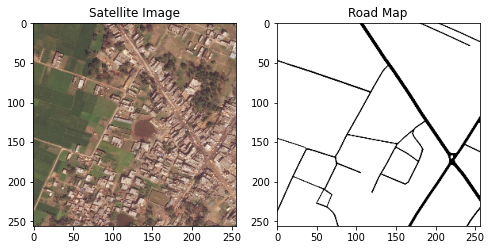

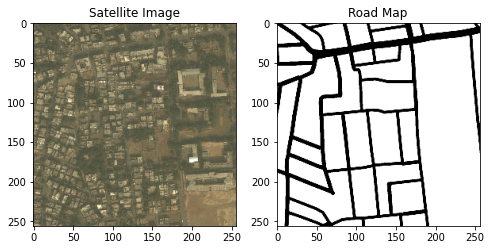

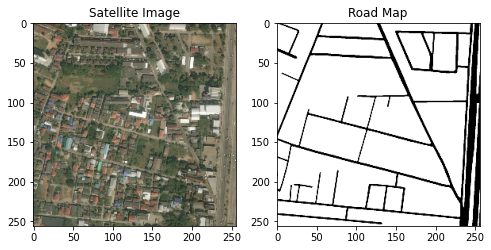

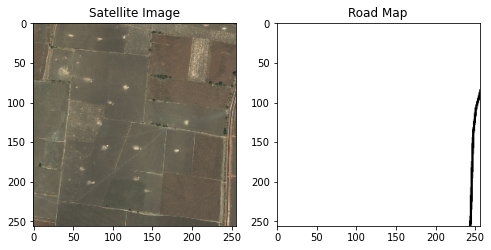

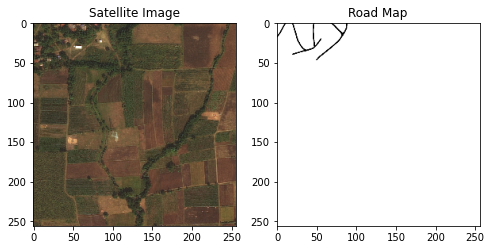

In [15]:
for i in list(np.random.choice(range(len(X_train)), size=5)):
    display_img_mask(i)
    

In [16]:
def Conv2DBlock(inputs, num_filters, kernel_size, doBatchNorm = True):
    x = layers.Conv2D(filters=num_filters, kernel_size=(kernel_size, kernel_size),
                      kernel_initializer='he_normal', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters=num_filters, kernel_size=(kernel_size, kernel_size),
                      kernel_initializer='he_normal', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    return x
    

In [17]:
def get_unet_model(inputs, num_filters, kernel_size=3):
    # encoder
    c1 = Conv2DBlock(inputs, num_filters*1, kernel_size)
    p1 = layers.MaxPooling2D((2,2))(c1)
    
    c2 = Conv2DBlock(p1, num_filters*2, kernel_size)
    p2 = layers.MaxPooling2D((2,2))(c2)
    
    c3 = Conv2DBlock(p2, num_filters*4, kernel_size)
    p3 = layers.MaxPooling2D((2,2))(c3)
    
    c4 = Conv2DBlock(p3, num_filters*8, kernel_size)
    p4 = layers.MaxPooling2D((2,2))(c4)
    
    c5 = Conv2DBlock(p4, num_filters*16, kernel_size)
    
    # decoder
    u6 = layers.Conv2DTranspose(num_filters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = Conv2DBlock(u6, num_filters*8, kernel_size)
    
    u7 = layers.Conv2DTranspose(num_filters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = Conv2DBlock(u7, num_filters*4, kernel_size)
    
    u8 = layers.Conv2DTranspose(num_filters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = Conv2DBlock(u8, num_filters*2, kernel_size)
    
    u9 = layers.Conv2DTranspose(num_filters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = Conv2DBlock(u9, num_filters*1, kernel_size)
    
    # output layer
    output = layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    
    model = models.Model(inputs = [inputs], outputs = [output])
    
    return model


In [18]:
num_filters = 16
kernel_size = 3

tf.keras.backend.clear_session()

inputs = layers.Input((image_size, image_size, 3))

unet = get_unet_model(inputs, num_filters, kernel_size)

unet.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'] )


In [19]:
unet.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

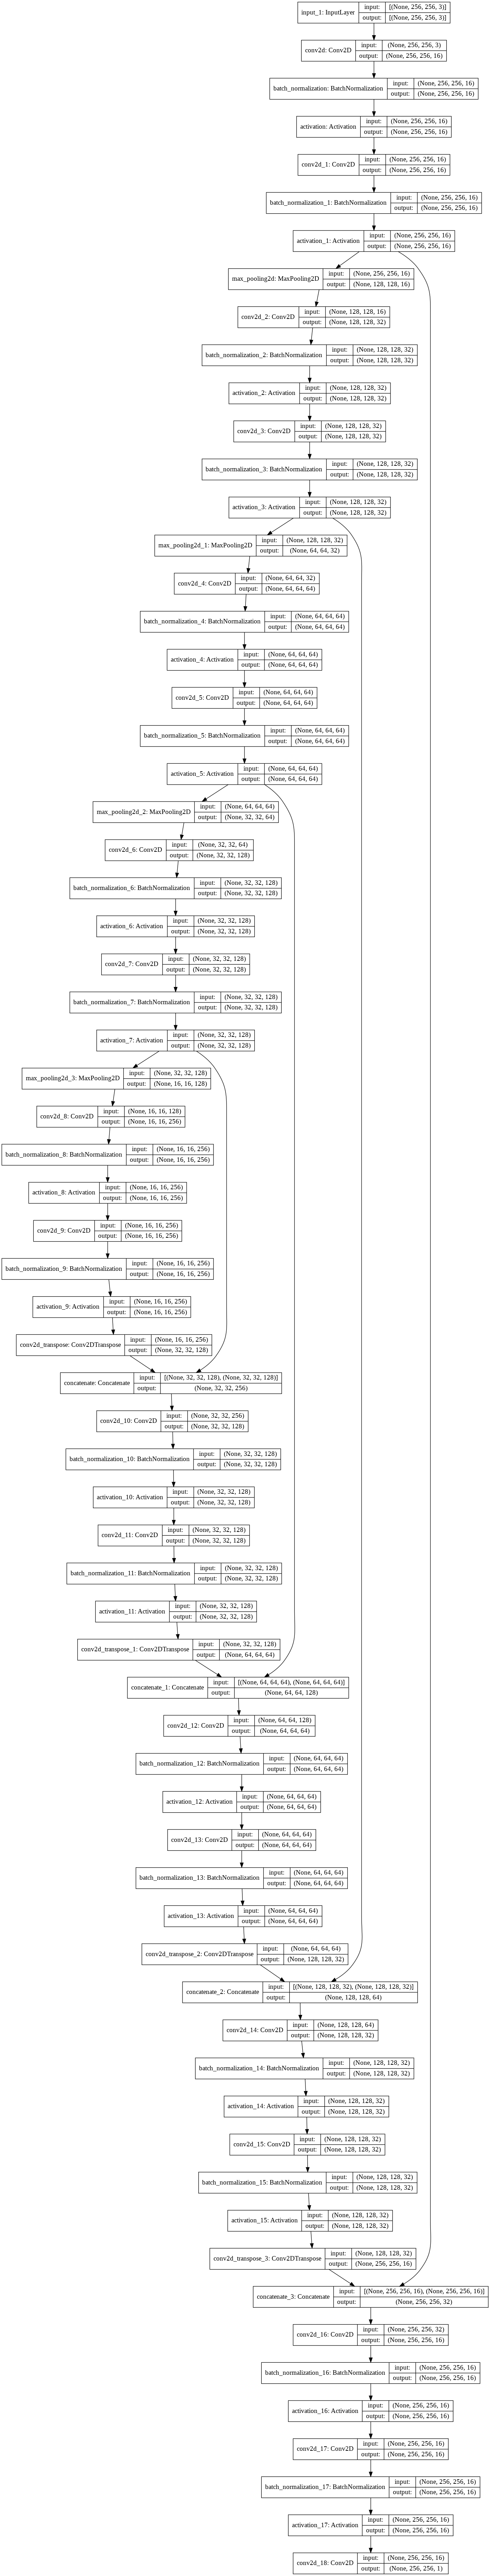

In [20]:
tf.keras.utils.plot_model(unet, to_file='unet_base_model_architecture.png', show_shapes=True, show_layer_names=True)


In [21]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=8, verbose=1, 
                                           restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, 
                                               verbose=1),
             tf.keras.callbacks.ModelCheckpoint('satellite_segmentation_base_model.h5', 
                                             save_best_only=True, save_freq='epoch')]

epochs = 5
history = unet.fit(X_train, y_train,
                       epochs=epochs, batch_size=64,
                       validation_split=0.25, callbacks=callbacks,
                       verbose=1)


Epoch 1/5
73/73 [==============================] - 53s 448ms/step - loss: 0.3293 - accuracy: 0.9261 - val_loss: 14.2155 - val_accuracy: 0.0628
Epoch 2/5
73/73 [==============================] - 29s 396ms/step - loss: 0.2054 - accuracy: 0.9532 - val_loss: 6.6194 - val_accuracy: 0.3892
Epoch 3/5
73/73 [==============================] - 29s 396ms/step - loss: 0.1722 - accuracy: 0.9533 - val_loss: 0.1810 - val_accuracy: 0.9462
Epoch 4/5
73/73 [==============================] - 29s 396ms/step - loss: 0.1507 - accuracy: 0.9536 - val_loss: 0.1582 - val_accuracy: 0.9534
Epoch 5/5
73/73 [==============================] - 29s 396ms/step - loss: 0.1313 - accuracy: 0.9558 - val_loss: 0.1598 - val_accuracy: 0.9536


In [22]:
def display_img_mask_pred(index, save_fig=False):
    
    fig, ax = plt.subplots(1,3, figsize=(10,4))
    
    ax[0].imshow(X_train[index])
    ax[0].set_title('Satellite Image')
    
    ax[1].imshow(y_train[index], cmap='Greys')
    ax[1].set_title('Road Map')
    
    predict_data = unet.predict(X_train[index].reshape(-1, 256, 256, 3))[0]
    
    ax[2].imshow(predict_data[:, :, 0], cmap='Greys')
    ax[2].set_title('Predicted Road Map')
    
    plt.tight_layout()
    
    if save_fig:
        fig.savefig(f'figures/predicted_road_map_base_model_{index}.png', dpi=200)
        

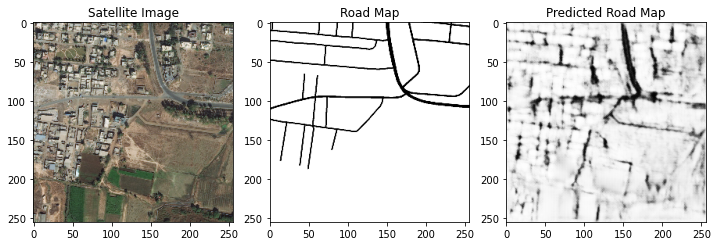

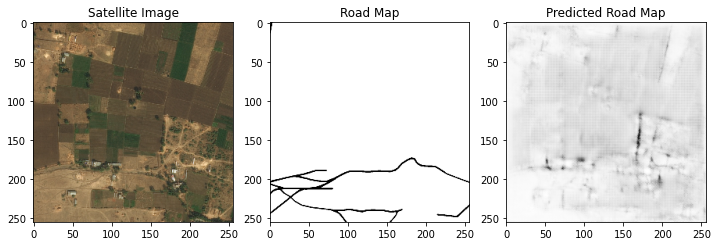

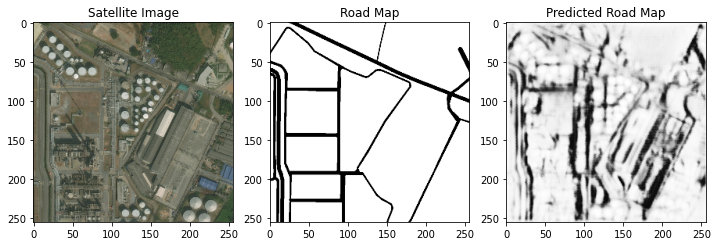

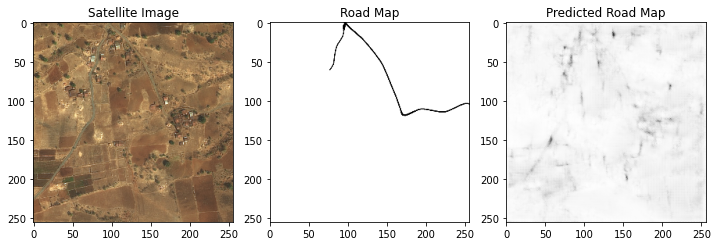

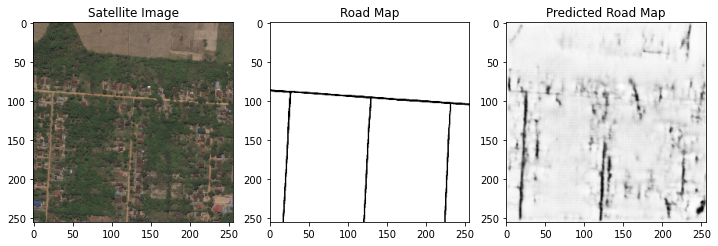

In [23]:
for i in list(np.random.choice(range(len(X_train)), size=5)):
    display_img_mask_pred(i)
    

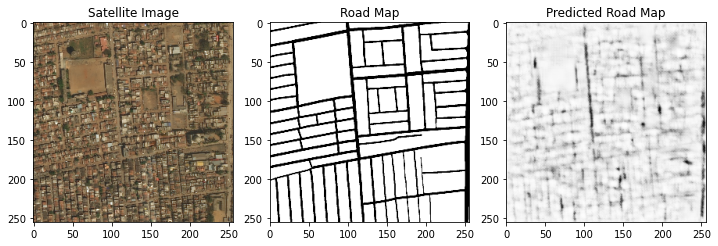

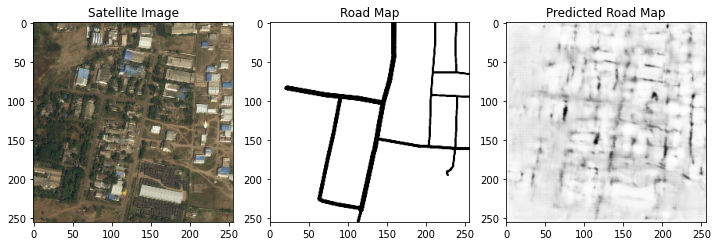

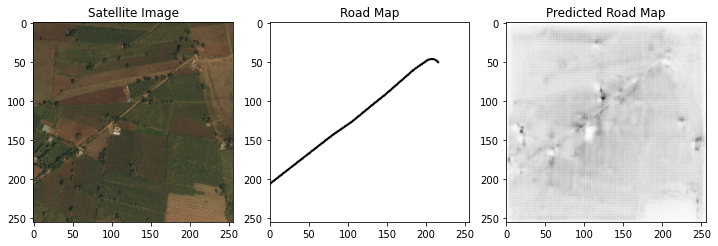

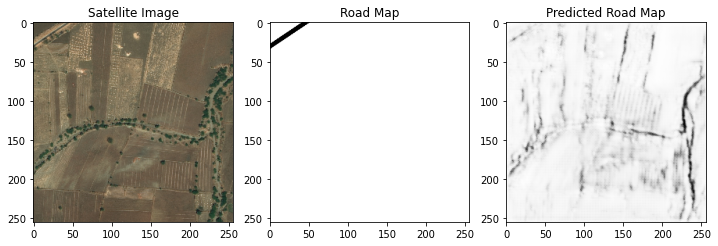

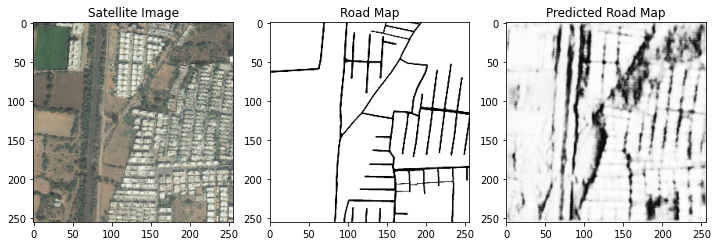

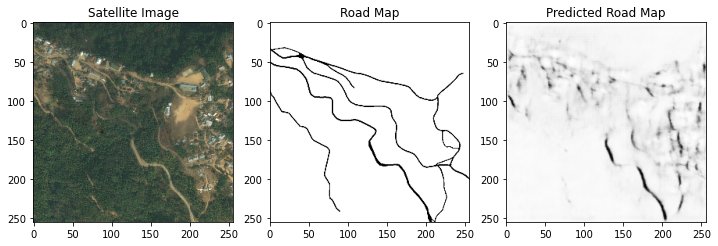

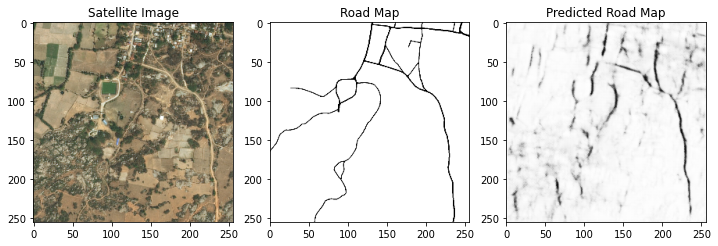

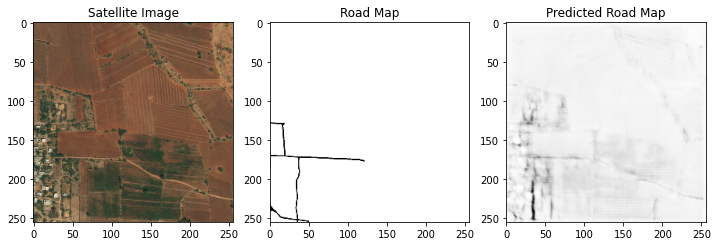

In [24]:
follow_index = [2272, 3492, 5252, 5540, 2896, 6138, 5161, 758]
for i in follow_index:
    display_img_mask_pred(i, save_fig=True)

In [26]:
from google.colab import files

for i in follow_index:
  files.download(f'figures/predicted_road_map_base_model_{i}.png') 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
files.download('satellite_segmentation_base_model.h5')
files.download('unet_base_model_architecture.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>